<a href="https://colab.research.google.com/github/nish700/Time-Series-forecasting/blob/main/nifty50_minor_project_tf_2_updates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nifty50 open value prediction

In this project , we did time series prediction combination of stacked CNN and LSTM layers. The model architecture have been build using tensorflow framework and python language is used for coding. Open Price of Nifty 50 index is downloaded from https://www.nseindia.com/ . Data is cleaned and then used for prediction purposes. Open price is being predicted to help the traders make the strategy for the next day and have profitable trades.

###import and clean up

In [ ]:
!pip install openpyxl==3.0.0

     |████████████████████████████████| 172 kB 4.1 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=1e8a7dd7ae4906a3c1420d90a5a41b5295f28859ede7602274413a08d2d6a117
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import math

from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.nn import leaky_relu
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
nifty_data = pd.read_excel('/content/drive/MyDrive/Datasets/MTP_data/final_data_v2.xlsx')

In [ ]:
nifty_data.shape

(2882, 14)

In [ ]:
nifty_data.isna().sum()

Date                                   0
Open                                   0
High                                   0
Low                                    0
Close                                  0
Shares Traded                          0
Turnover (Rs. Cr)                      0
VIX Price                              0
VIX Open                               0
VIX High                               0
VIX Low                                0
VIX Chg%                               0
Net Purchase / Sales FII Rs Crores    44
Net Purchase / Sales DII Rs Crores    44
dtype: int64

In [ ]:
nifty_data_1 = nifty_data[['Date','Open','High','Low','Close']]
nifty_data_1.head()

,Date,Open,High,Low,Close
0,2010-04-01,5249.20,5298.60,5249.20,5290.50
1,2010-04-05,5291.40,5377.55,5291.40,5368.40
2,2010-04-06,5369.65,5388.65,5351.70,5366.00
3,2010-04-07,5365.70,5399.65,5345.05,5374.65
4,2010-04-08,5376.30,5383.65,5290.25,5304.45


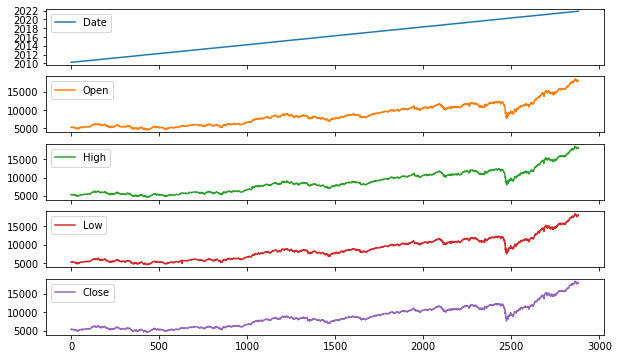

In [ ]:
nifty_data_1.plot(figsize=(10,6),subplots=True)
plt.show()

               Open     High      Low    Close
Date                                          
2010-04-01  5249.20  5298.60  5249.20  5290.50
2010-04-05  5291.40  5377.55  5291.40  5368.40
2010-04-06  5369.65  5388.65  5351.70  5366.00
2010-04-07  5365.70  5399.65  5345.05  5374.65
2010-04-08  5376.30  5383.65  5290.25  5304.45


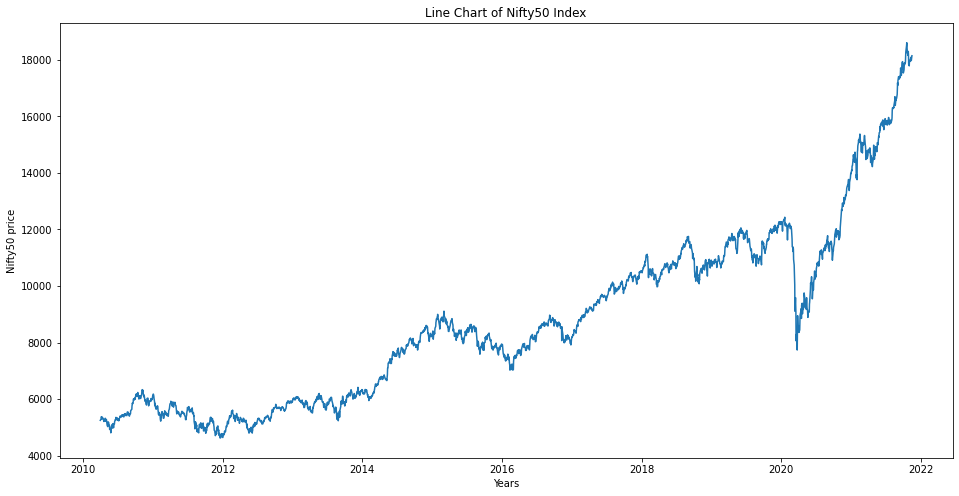

In [ ]:
nifty_data_2 = nifty_data_1.set_index(keys='Date')
print(nifty_data_2.head())

plt.figure(figsize=(16,8))
plt.plot(nifty_data_2['Open'])
plt.xlabel('Years')
plt.ylabel('Nifty50 price')
plt.title('Line Chart of Nifty50 Index')
plt.show()

In [ ]:
nifty_data_2 = nifty_data_2[['Open']]
nifty_data_2.head()

,Open
Date,
2010-04-01,5249.20
2010-04-05,5291.40
2010-04-06,5369.65
2010-04-07,5365.70
2010-04-08,5376.30


In [ ]:
nifty_data_2.shape

(2882, 1)

In [ ]:
#scaling the records
scaler = MinMaxScaler(feature_range = (0,1))
nifty_data_2['Open'] = scaler.fit_transform(nifty_data_2['Open'].values.reshape(-1,1))

In [ ]:
nifty_data_2.tail()
nifty_data_2.shape

(2882, 1)

In [ ]:
def load_data( index_price ,seq_length):
  data_raw = index_price.values
  data_lst = []

  #create all possible of sequence
  for index in range(len(data_raw) - seq_length):
    data_lst.append(data_raw[index: index + seq_length])

  data_lst = np.array(data_lst)

  train_set = int(np.round(0.8 * data_lst.shape[0]))
  test_set = int(np.round(0.2 * data_lst.shape[0]))

  X_train = data_lst[:train_set, :-1,:]
  X_val = data_lst[train_set:, :-1]

  y_train = data_lst[:train_set, -1, :]
  y_val = data_lst[train_set:,-1,:]

  return X_train, X_val , y_train, y_val

In [ ]:
epochs = 300
batch_size = 64
seq_len = 6

In [ ]:
X_train, X_val, y_train, y_val = load_data(nifty_data_2, seq_len)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2301, 5, 1), (575, 5, 1), (2301, 1), (575, 1))

In [ ]:
X_train.shape

(2301, 5, 1)

In [ ]:
# def scheduler(epoch):

#   if (epoch) <= 150:
#     lrate = (10 ** (-5)) * (epoch / 150)
#   elif epoch <= 400:
#     initial_lrate = (10 ** (-5))
#     k = 0.01
#     lrate = initial_lrate * math.exp(-k * (epoch - 150))
#   else:
#     lrate = (10 ** (-6))

#   return lrate

In [ ]:
# scheduler(epochs)
# type(epochs)

In [ ]:
# callback = LearningRateScheduler(scheduler(epochs))

### Stacked LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
# model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam', metrics = RootMeanSquaredError())

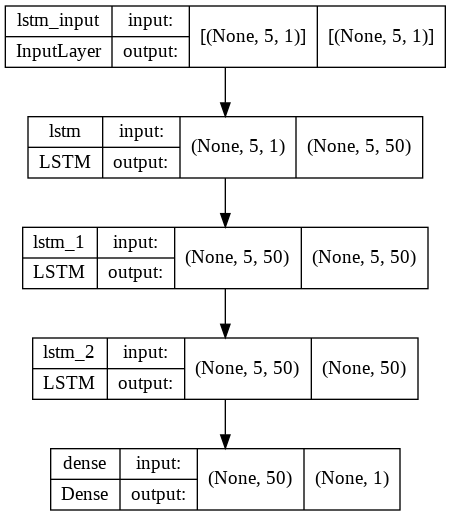

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t0 = time.time()
# model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)
model_hist_1 = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 16s 118ms/step - loss: 0.0191 - root_mean_squared_error: 0.1384 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 2/300
36/36 [==============================] - 1s 26ms/step - loss: 6.0887e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 3/300
36/36 [==============================] - 1s 23ms/step - loss: 1.5111e-04 - root_mean_squared_error: 0.0123 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 4/300
36/36 [==============================] - 1s 25ms/step - loss: 1.1894e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 5/300
36/36 [==============================] - 1s 26ms/step - loss: 1.0741e-04 - root_mean_squared_error: 0.0104 - val_loss: 4.8193e-04 - val_root_mean_squared_error: 0.0220
Epoch 6/300
36/36 [==============================] - 1s 24ms/step - loss: 9.7680e-05 - root_mean_squared_error: 0.0099

In [ ]:
model_hist_dict = model_hist_1.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

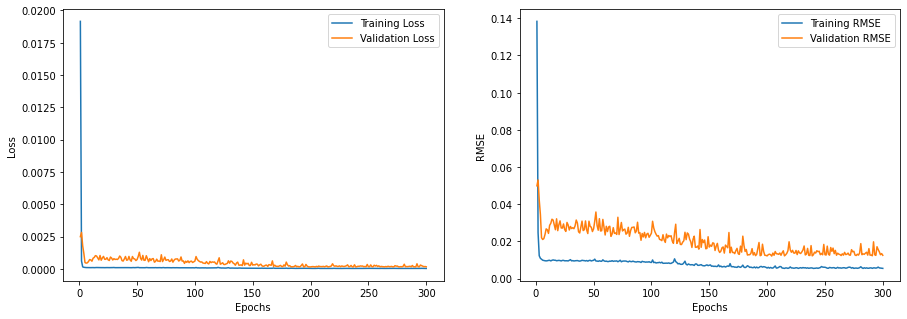

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=model.predict(X_train)
y_val_predict=model.predict(X_val)

In [ ]:
#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

In [ ]:
my_list = map(lambda x: x[0], y_train_t)
ser_1 = pd.Series(my_list)
ser_1

my_list_2 = map(lambda x: round(x[0]), y_train_predict)
ser_2 = pd.Series(my_list_2)
ser_2

pd.concat([ser_1, ser_2], names=['true','predicted'],axis= 1)

In [ ]:
my_list = map(lambda x: x[0], y_val_t)
ser_1 = pd.Series(my_list)
ser_1

my_list_2 = map(lambda x: round(x[0]), y_val_predict)
ser_2 = pd.Series(my_list_2)
ser_2

pd.concat([ser_1, ser_2], names=['true','predicted'],axis= 1)

In [ ]:
### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

Train Score: 76.58 RMSE
Test Score: 175.07 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.007864601015593576
test MAPE :  0.010200918146145809


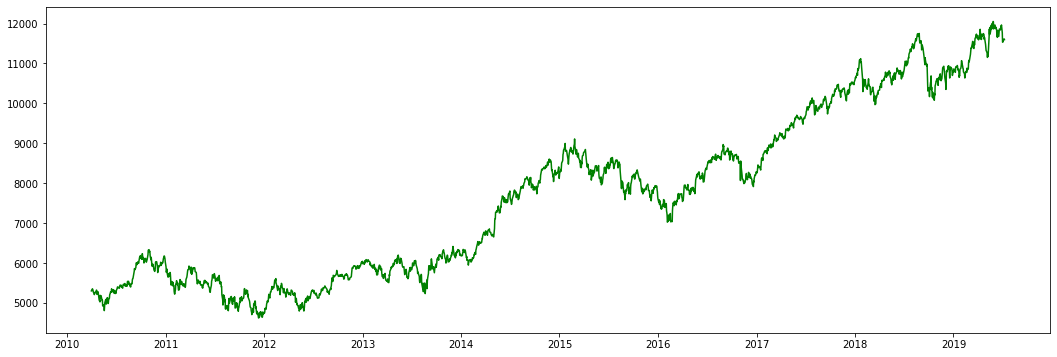

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Open Price')

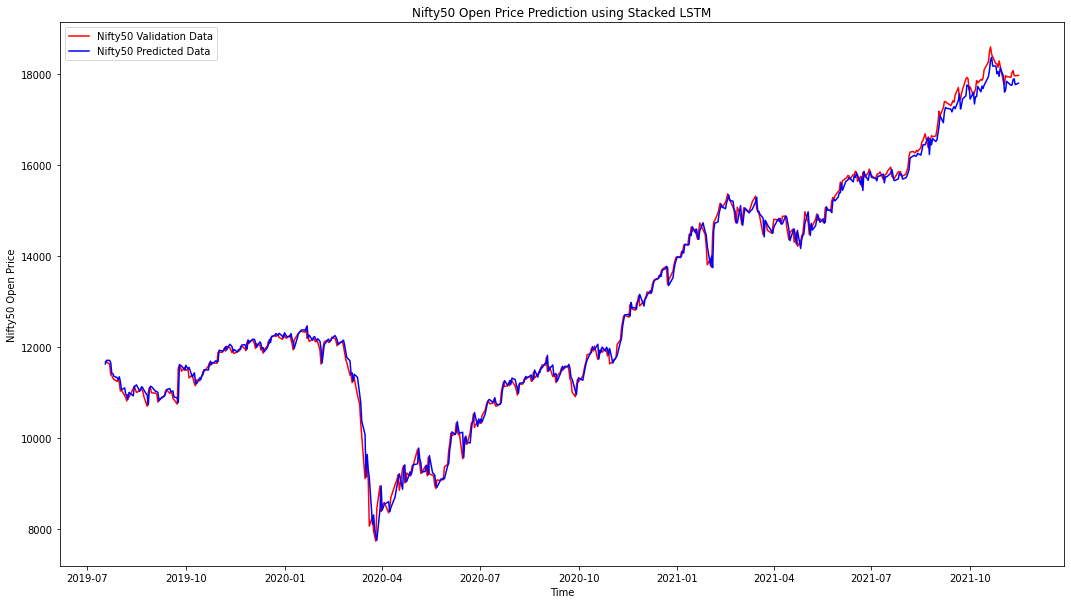

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 10))
axes.xaxis_date()
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Nifty50 Validation Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Nifty50 Predicted Data')
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

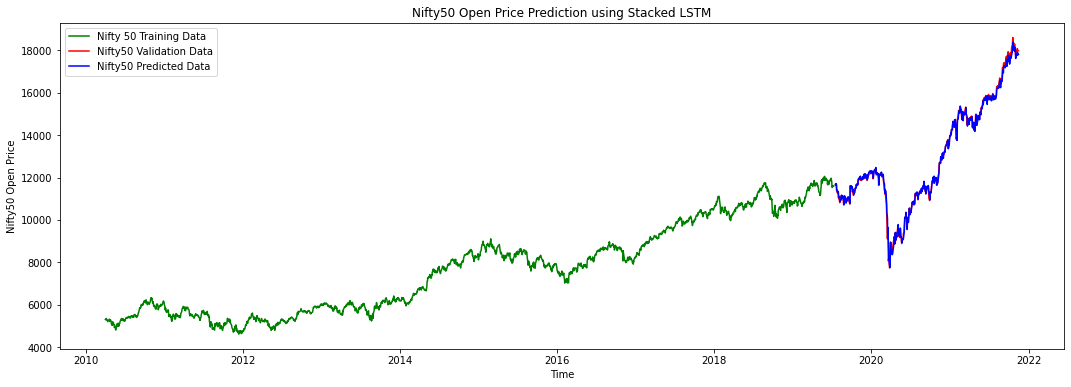

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Nifty50 Validation Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Nifty50 Predicted Data')
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### Stacked LSTM_2

In [ ]:
model_1=Sequential()
model_1.add(LSTM(200,input_shape=(X_train.shape[1],1),activation = leaky_relu ,return_sequences=True))
model_1.add(LSTM(200, activation = leaky_relu))
model_1.add(Dense(200, activation = leaky_relu))
model_1.add(Dense(200 ,activation = leaky_relu))
model_1.add(Dense(50 , activation = leaky_relu))
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

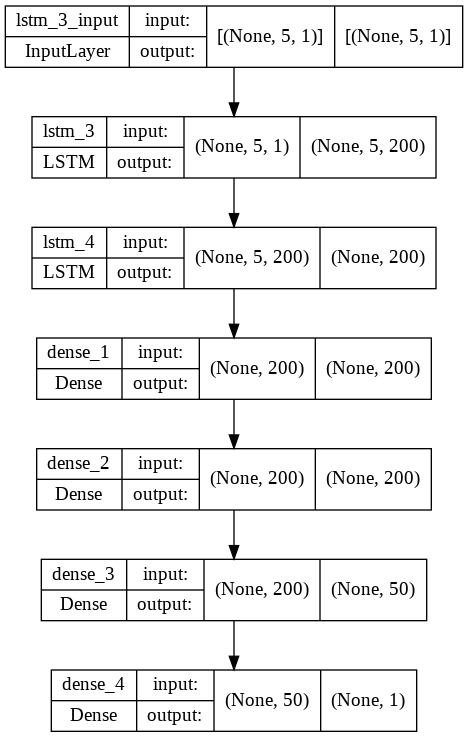

In [ ]:
plot_model(model_1, show_shapes = True)

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_4 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 50)                10050     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 572,901
Trainable params: 572,901
Non-tr

In [ ]:
t0 = time.time()
model_hist_1 = model_1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)#, callbacks = [callback])
# model_hist_1 = model_1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 59ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 2/300
36/36 [==============================] - 2s 48ms/step - loss: 3.4301e-04 - root_mean_squared_error: 0.0185 - val_loss: 6.1553e-04 - val_root_mean_squared_error: 0.0248
Epoch 3/300
36/36 [==============================] - 2s 50ms/step - loss: 8.2603e-05 - root_mean_squared_error: 0.0091 - val_loss: 3.6410e-04 - val_root_mean_squared_error: 0.0191
Epoch 4/300
36/36 [==============================] - 2s 47ms/step - loss: 8.0887e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.6289e-04 - val_root_mean_squared_error: 0.0190
Epoch 5/300
36/36 [==============================] - 2s 48ms/step - loss: 8.4042e-05 - root_mean_squared_error: 0.0092 - val_loss: 4.3238e-04 - val_root_mean_squared_error: 0.0208
Epoch 6/300
36/36 [==============================] - 2s 50ms/step - loss: 8.6479e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_1.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

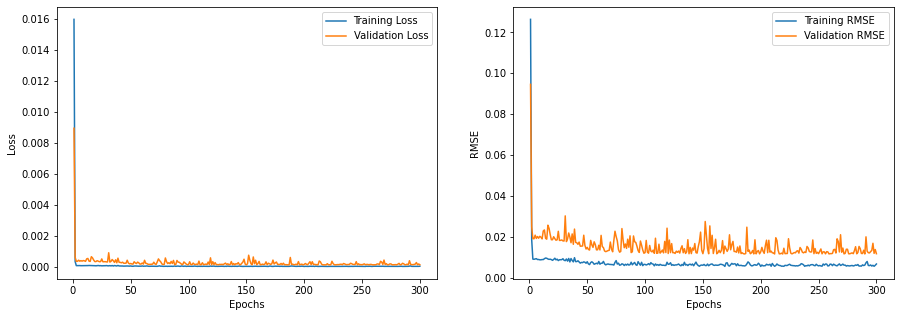

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=model_1.predict(X_train)
y_val_predict=model_1.predict(X_val)

In [ ]:
#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

In [ ]:
### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

Train Score: 77.86 RMSE
Test Score: 163.92 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.008030499910532427
test MAPE :  0.00950123590125393


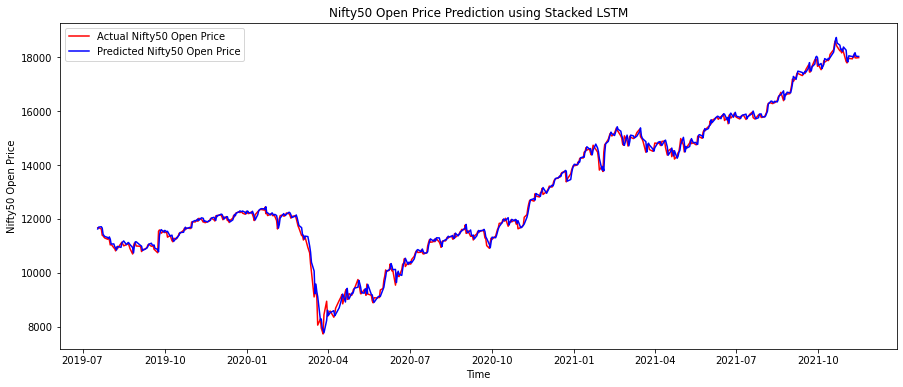

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN

In [ ]:
# Defining model Architecture
network = Sequential()
network.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
network.add(MaxPooling1D(pool_size=2))
network.add(Flatten())
network.add(Dense(100, activation='relu'))
network.add(Dense(1))
# network.compile(optimizer='adam', loss='mse')
network.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

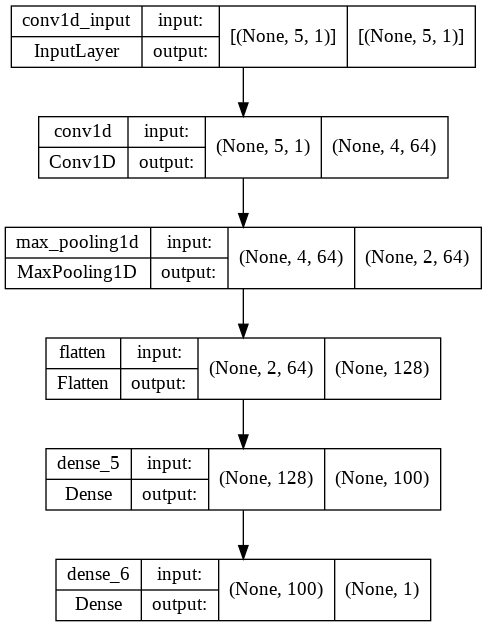

In [ ]:
plot_model(network, show_shapes = True)

In [ ]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               12900     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,193
Trainable params: 13,193
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit model
t0 = time.time()
# network.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_2 = network.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 1s 7ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 4.8037e-04 - val_root_mean_squared_error: 0.0219
Epoch 2/300
36/36 [==============================] - 0s 3ms/step - loss: 1.1567e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.3326e-04 - val_root_mean_squared_error: 0.0183
Epoch 3/300
36/36 [==============================] - 0s 3ms/step - loss: 7.5147e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.1153e-04 - val_root_mean_squared_error: 0.0177
Epoch 4/300
36/36 [==============================] - 0s 3ms/step - loss: 6.3832e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.2447e-04 - val_root_mean_squared_error: 0.0180
Epoch 5/300
36/36 [==============================] - 0s 4ms/step - loss: 6.4839e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.0181e-04 - val_root_mean_squared_error: 0.0174
Epoch 6/300
36/36 [==============================] - 0s 3ms/step - loss: 6.1114e-05 - root_mean_squared_error

In [ ]:
model_hist_dict = model_hist_2.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

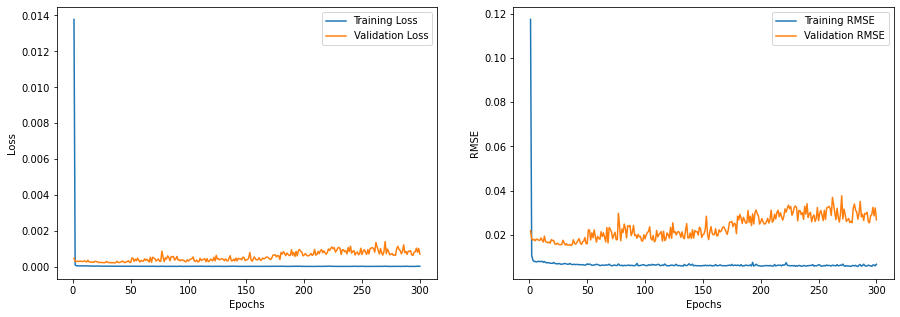

In [ ]:
## loss plotting
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict_1=network.predict(X_train)
y_val_predict_1=network.predict(X_val)


#Transformback to original form
y_train_predict_1=scaler.inverse_transform(y_train_predict_1)
y_val_predict_1=scaler.inverse_transform(y_val_predict_1)
y_train_1 = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_1 = scaler.inverse_transform(y_val)


### Calculate RMSE performance metrics
train_rmse_1 = np.sqrt(mean_squared_error(y_train_1,y_train_predict_1))
### Test Data RMSE
test_rmse_1 = np.sqrt(mean_squared_error(y_val,y_val_predict_1))
print('Train Score: %.2f RMSE' % (train_rmse_1))
print('Test Score: %.2f RMSE' % (test_rmse_1))

Train Score: 89.60 RMSE
Test Score: 13004.76 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_1 , y_train_predict_1)
test_mape = mean_absolute_percentage_error(y_val , y_val_predict_1)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.009087353952658573
test MAPE :  22345.0348025918


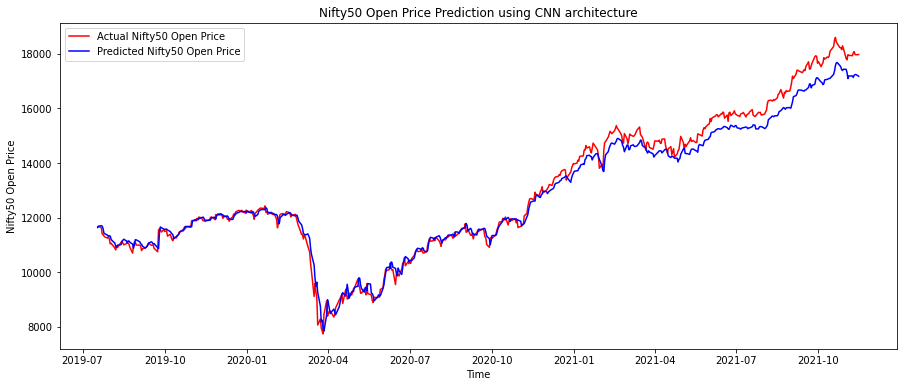

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_1):].index, y_val_1, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict_1):].index, y_val_predict_1, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN architecture')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
plt.savefig('nifty50_cnn.png')
plt.show()

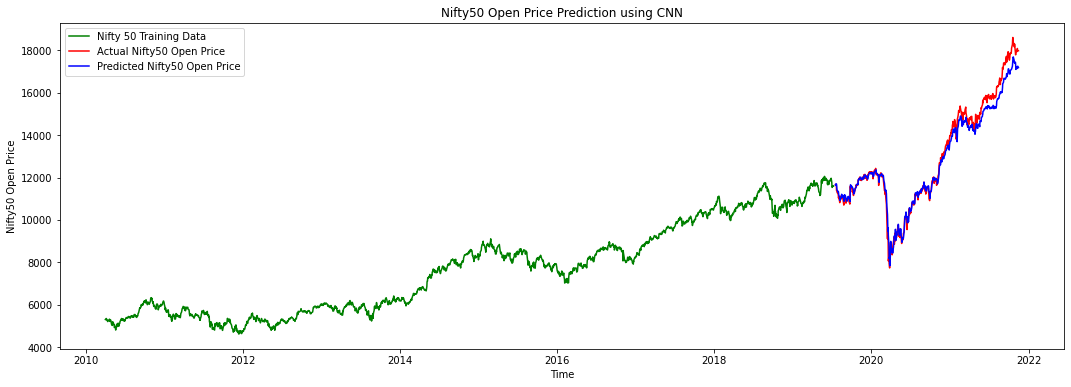

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_1)].index, y_train_1, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_1):].index, y_val_1, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict_1):].index, y_val_predict_1, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()


### CNN-LSTM

In [ ]:
# Defining model Architecture
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm.add(LSTM(50,return_sequences=True))
cnn_lstm.add(LSTM(50))
cnn_lstm.add(Dense(1))
# cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

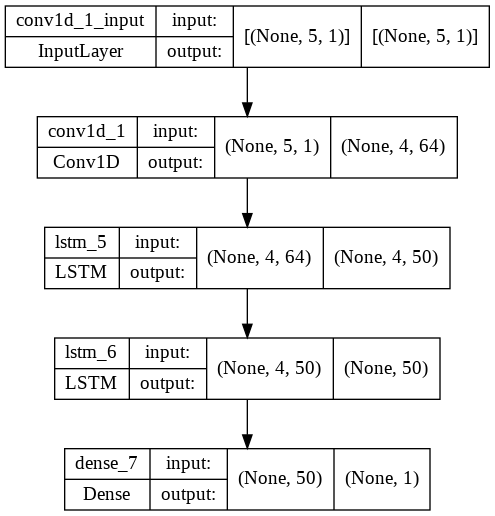

In [ ]:
plot_model(cnn_lstm, show_shapes = True)

In [ ]:
cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 lstm_5 (LSTM)               (None, 4, 50)             23000     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43,443
Trainable params: 43,443
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
t0 = time.time()
# cnn_lstm.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_3 = cnn_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = epochs, batch_size=batch_size, verbose = 1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 34ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 2/300
36/36 [==============================] - 0s 10ms/step - loss: 6.4010e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 3/300
36/36 [==============================] - 0s 10ms/step - loss: 1.3040e-04 - root_mean_squared_error: 0.0114 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/300
36/36 [==============================] - 0s 10ms/step - loss: 1.0839e-04 - root_mean_squared_error: 0.0104 - val_loss: 8.3899e-04 - val_root_mean_squared_error: 0.0290
Epoch 5/300
36/36 [==============================] - 0s 10ms/step - loss: 9.3095e-05 - root_mean_squared_error: 0.0096 - val_loss: 6.0160e-04 - val_root_mean_squared_error: 0.0245
Epoch 6/300
36/36 [==============================] - 0s 10ms/step - loss: 8.4473e-05 - root_mean_squared_error: 0.00

In [ ]:
model_hist_dict = model_hist_3.history

loss = model_hist_dict['loss']
root_mean_square_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1 , len(loss) + 1)

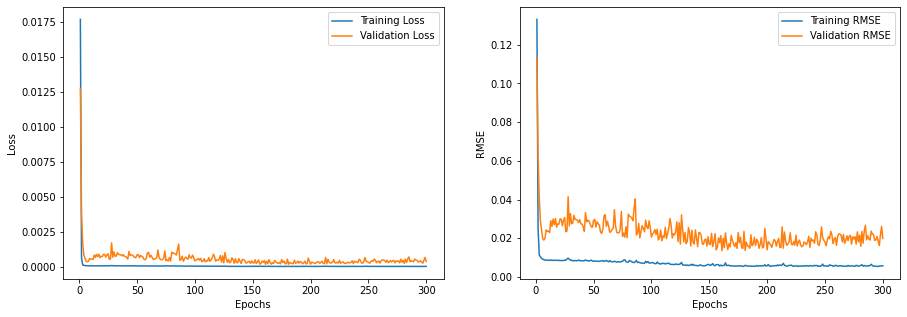

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_square_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 79.02 RMSE
Test Score: 277.27 RMSE
************************
train MAPE :  0.008371565769471007
test MAPE :  0.015035619442096776


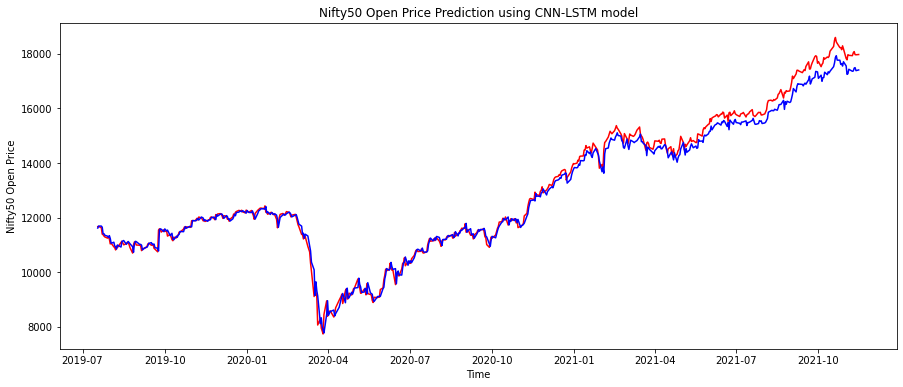

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm.predict(X_train)
y_val_predict=cnn_lstm.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


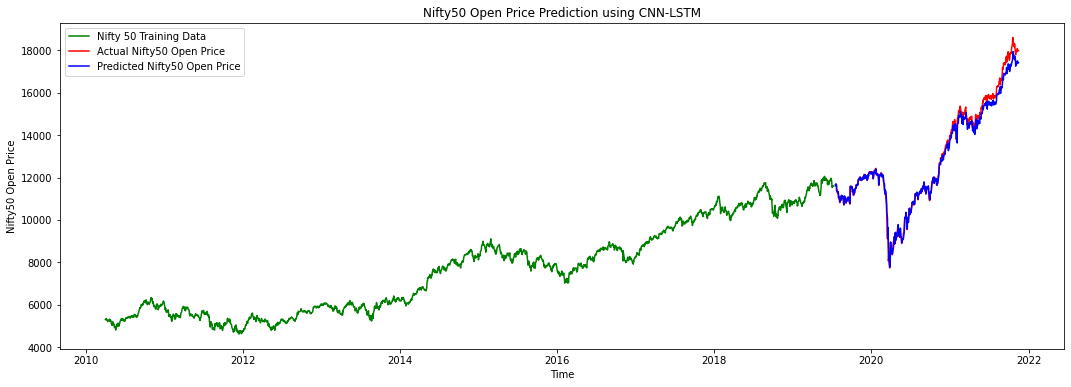

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
plt.show()

### CNN-LSTM 2

In [ ]:
# Defining model Architecture
cnn_lstm_2 = Sequential()
cnn_lstm_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_2.add(MaxPooling1D(pool_size=2))
cnn_lstm_2.add(LSTM(50,return_sequences=True))
cnn_lstm_2.add(LSTM(50))
cnn_lstm_2.add(Dense(1))
# cnn_lstm_2.compile(optimizer='adam', loss='mse')
cnn_lstm_2.compile(loss= 'mean_squared_error', optimizer='adam',metrics = RootMeanSquaredError())

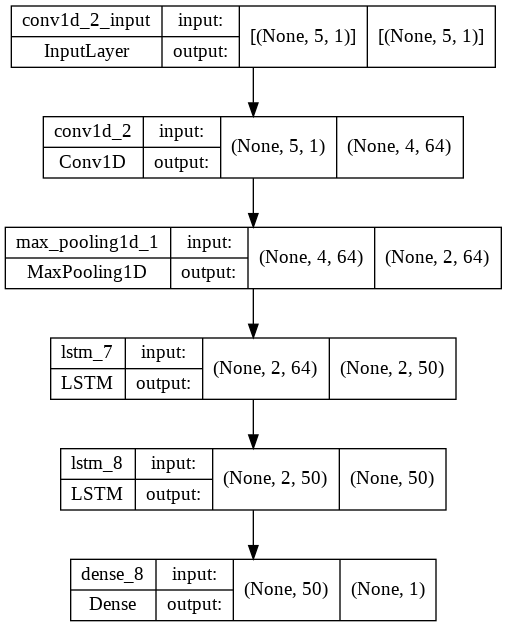

In [ ]:
plot_model(cnn_lstm_2, show_shapes = True)

In [ ]:
cnn_lstm_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 2, 50)             23000     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43,443
Trainable params: 43,443
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit model
t0 = time.time()
# cnn_lstm_2.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_4 = cnn_lstm_2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs= epochs , batch_size = batch_size , verbose = 1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 32ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 2/300
36/36 [==============================] - 0s 8ms/step - loss: 0.0032 - root_mean_squared_error: 0.0566 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 3/300
36/36 [==============================] - 0s 7ms/step - loss: 2.2002e-04 - root_mean_squared_error: 0.0148 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 4/300
36/36 [==============================] - 0s 8ms/step - loss: 1.4346e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 5/300
36/36 [==============================] - 0s 7ms/step - loss: 1.1561e-04 - root_mean_squared_error: 0.0108 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 6/300
36/36 [==============================] - 0s 8ms/step - loss: 9.8475e-05 - root_mean_squared_error: 0.0099 - val_loss: 0.

In [ ]:
model_hist_dict = model_hist_4.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

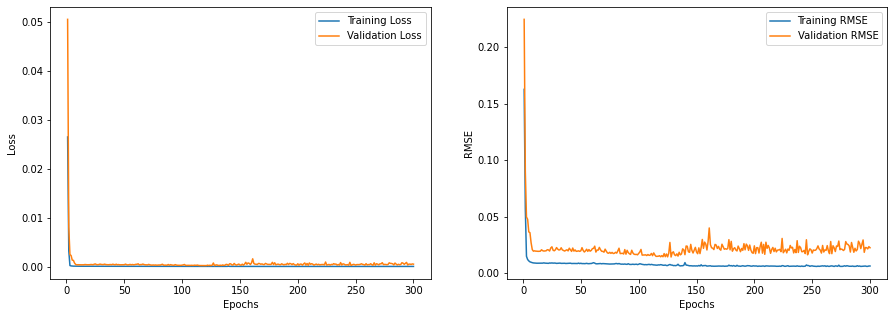

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 79.60 RMSE
Test Score: 312.87 RMSE
*************************
train MAPE :  0.008285822703963148
test MAPE :  0.017300946138355446


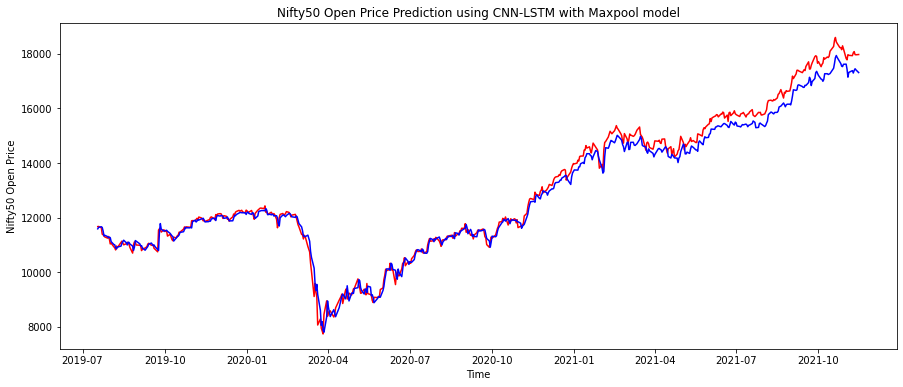

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_2.predict(X_train)
y_val_predict=cnn_lstm_2.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_cn = scaler.inverse_transform(y_train)
y_val_cn = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_cn,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_cn,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_cn , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_cn , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cn):].index, y_val_cn, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM with Maxpool model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


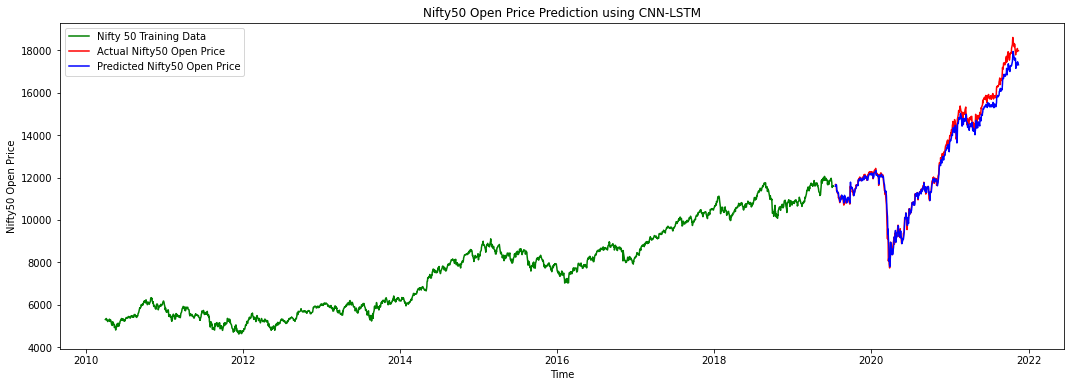

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_cn)].index, y_train_cn, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cn):].index, y_val_cn, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()


### CNN-LSTM 3

In [ ]:
# Defining model Architecture
cnn_lstm_3 = Sequential()
cnn_lstm_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_3.add(MaxPooling1D(pool_size=2))
cnn_lstm_3.add(Conv1D(filters=128, kernel_size=2, padding='same',activation= 'relu'))
cnn_lstm_3.add(MaxPooling1D(pool_size=2))
cnn_lstm_3.add(LSTM(50,return_sequences=True))
cnn_lstm_3.add(LSTM(50))
cnn_lstm_3.add(Dense(1))
# cnn_lstm_3.compile(optimizer='adam', loss='mse')
cnn_lstm_3.compile(loss = 'mean_squared_error',optimizer='adam',metrics = RootMeanSquaredError())

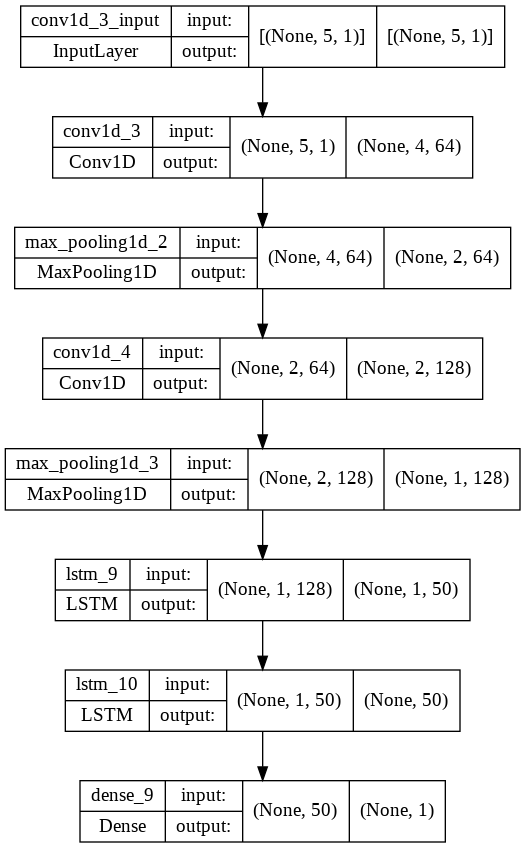

In [ ]:
plot_model(cnn_lstm_3, show_shapes= True)

In [ ]:
cnn_lstm_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 128)            16512     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 1, 50)             35800     
                                                                 
 lstm_10 (LSTM)              (None, 50)               

In [ ]:
# fit model
t0 = time.time()
model_hist_5 = cnn_lstm_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = batch_size, verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 33ms/step - loss: 0.0277 - root_mean_squared_error: 0.1665 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2308
Epoch 2/300
36/36 [==============================] - 0s 7ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 3/300
36/36 [==============================] - 0s 8ms/step - loss: 2.1559e-04 - root_mean_squared_error: 0.0147 - val_loss: 6.6792e-04 - val_root_mean_squared_error: 0.0258
Epoch 4/300
36/36 [==============================] - 0s 7ms/step - loss: 9.8478e-05 - root_mean_squared_error: 0.0099 - val_loss: 3.3911e-04 - val_root_mean_squared_error: 0.0184
Epoch 5/300
36/36 [==============================] - 0s 7ms/step - loss: 7.0370e-05 - root_mean_squared_error: 0.0084 - val_loss: 4.1286e-04 - val_root_mean_squared_error: 0.0203
Epoch 6/300
36/36 [==============================] - 0s 7ms/step - loss: 6.4969e-05 - root_mean_squared_error: 0.0081 - 

In [ ]:
model_hist_dict = model_hist_5.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

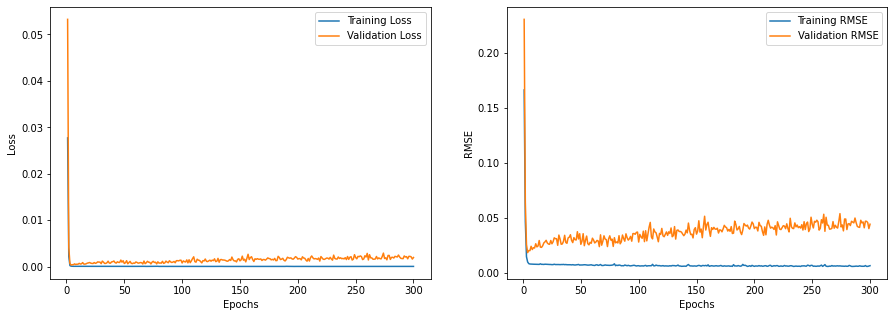

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 81.60 RMSE
Test Score: 619.18 RMSE
*************************
train MAPE :  0.008312737411336231
test MAPE :  0.028822202790646307


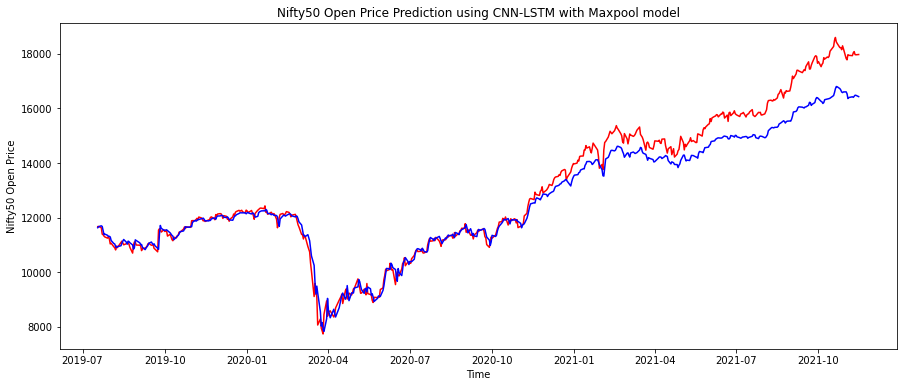

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_3.predict(X_train)
y_val_predict=cnn_lstm_3.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_cl = scaler.inverse_transform(y_train)
y_val_cl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_cl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_cl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_cl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_cl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)


# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cl):].index, y_val_cl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM with Maxpool model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


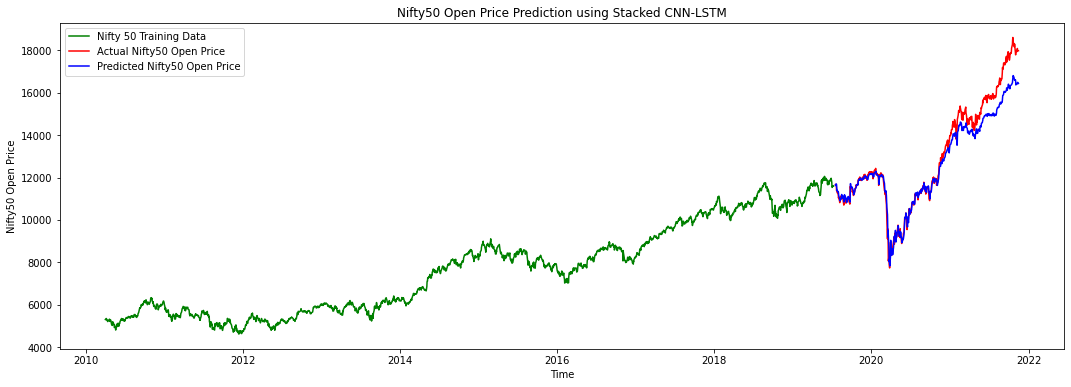

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_cl)].index, y_train_cl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cl):].index, y_val_cl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN-LSTM 4

In [ ]:
# Defining model Architecture
cnn_lstm_4 = Sequential()
cnn_lstm_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_4.add(Conv1D(filters=32, kernel_size=2, padding='same',activation= 'relu'))
cnn_lstm_4.add(Conv1D(filters=32, kernel_size=2, padding='same',activation= 'relu'))

cnn_lstm_4.add(LSTM(50,return_sequences=True))
cnn_lstm_4.add(LSTM(50))
cnn_lstm_4.add(Dense(1))
# cnn_lstm_4.compile(optimizer='adam', loss='mse')
cnn_lstm_4.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

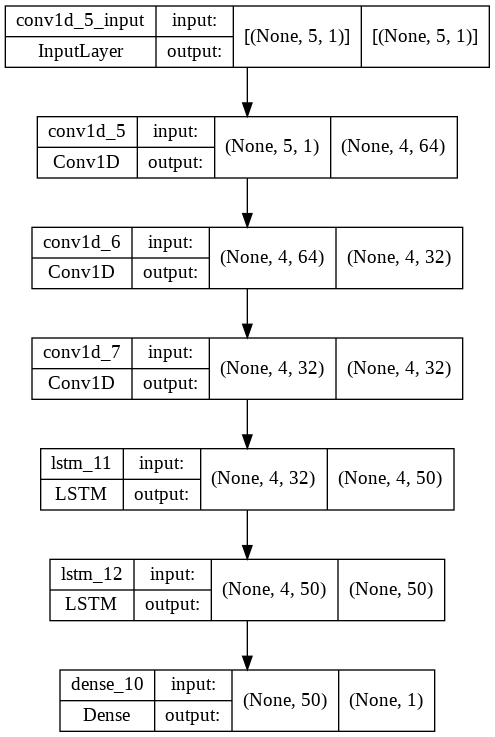

In [ ]:
plot_model(cnn_lstm_4, show_shapes=True)

In [ ]:
cnn_lstm_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 4, 64)             192       
                                                                 
 conv1d_6 (Conv1D)           (None, 4, 32)             4128      
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 32)             2080      
                                                                 
 lstm_11 (LSTM)              (None, 4, 50)             16600     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 43,251
Trainable params: 43,251
Non-trai

In [ ]:
# fit model
t0 = time.time()
model_hist_6 = cnn_lstm_4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 37ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 2/300
36/36 [==============================] - 0s 11ms/step - loss: 4.7079e-04 - root_mean_squared_error: 0.0217 - val_loss: 8.3219e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/300
36/36 [==============================] - 0s 12ms/step - loss: 8.8058e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.6253e-04 - val_root_mean_squared_error: 0.0190
Epoch 4/300
36/36 [==============================] - 0s 11ms/step - loss: 7.1910e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.2842e-04 - val_root_mean_squared_error: 0.0181
Epoch 5/300
36/36 [==============================] - 0s 11ms/step - loss: 6.6704e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.1963e-04 - val_root_mean_squared_error: 0.0179
Epoch 6/300
36/36 [==============================] - 0s 12ms/step - loss: 6.4409e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_6.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

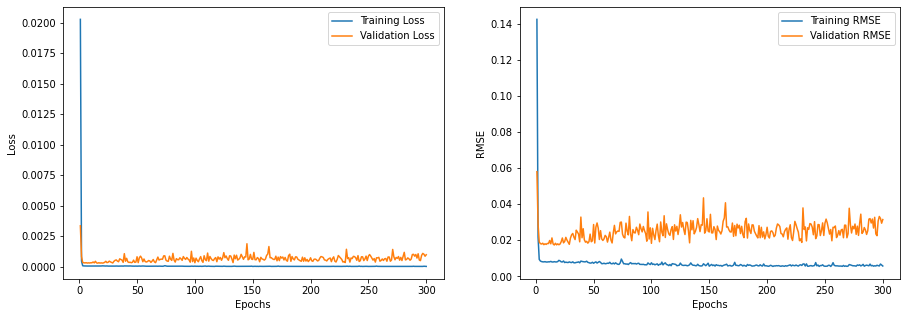

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 81.56 RMSE
Test Score: 439.52 RMSE
*************************
train MAPE :  0.008439212425350996
test MAPE :  0.022706894129067106


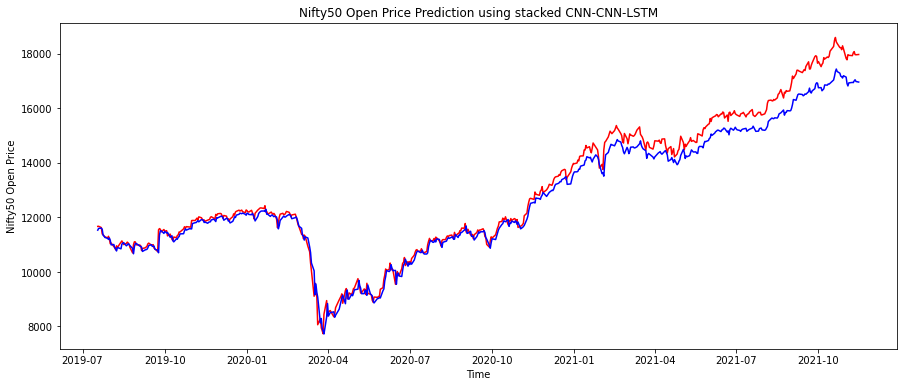

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_4.predict(X_train)
y_val_predict=cnn_lstm_4.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_ccl = scaler.inverse_transform(y_train)
y_val_ccl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_ccl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_ccl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))


print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_ccl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_ccl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using stacked CNN-CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


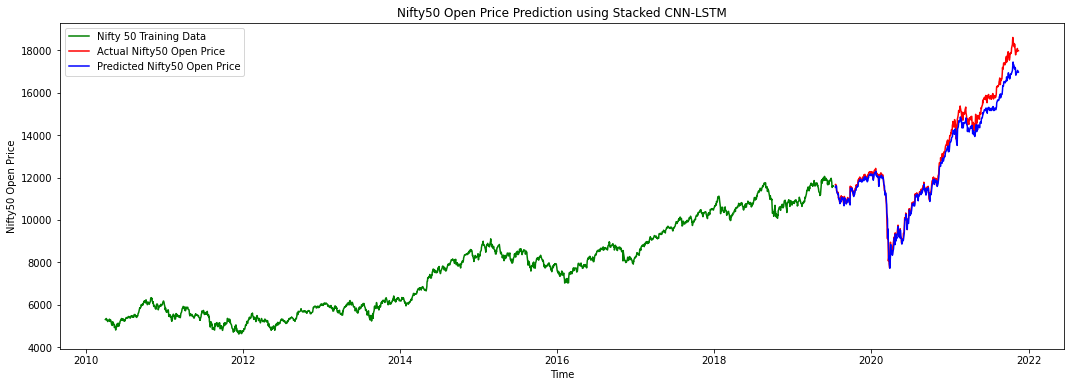

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_ccl)].index, y_train_ccl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN-LSTM 5

In [ ]:
# Defining model Architecture


cnn_lstm_5 = Sequential()
cnn_lstm_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))

cnn_lstm_5.add(LSTM(200, activation = leaky_relu, return_sequences=True))
cnn_lstm_5.add(LSTM(200, activation = leaky_relu))
cnn_lstm_5.add(Dense(200, activation = leaky_relu))
cnn_lstm_5.add(Dense(200 ,activation = leaky_relu))
cnn_lstm_5.add(Dense(50 , activation = leaky_relu))
cnn_lstm_5.add(Dense(1))
cnn_lstm_5.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())


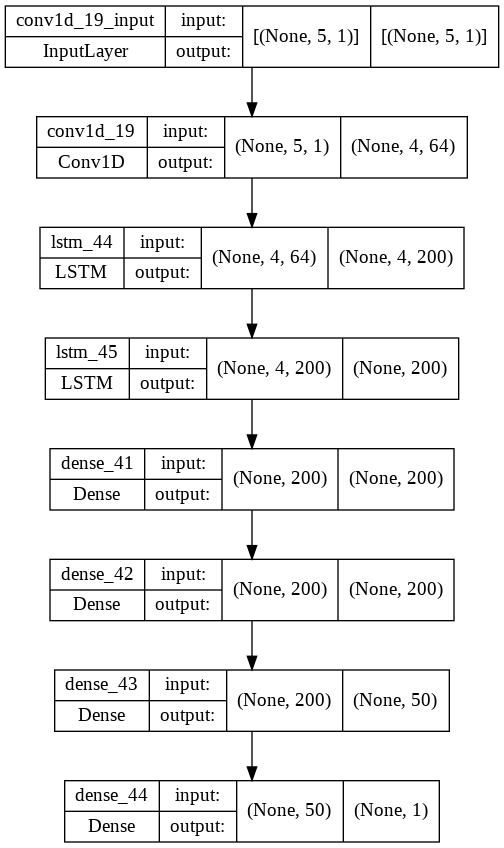

In [ ]:
plot_model(cnn_lstm_5, show_shapes=True)

In [ ]:
cnn_lstm_5.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 4, 64)             192       
                                                                 
 lstm_44 (LSTM)              (None, 4, 200)            212000    
                                                                 
 lstm_45 (LSTM)              (None, 200)               320800    
                                                                 
 dense_41 (Dense)            (None, 200)               40200     
                                                                 
 dense_42 (Dense)            (None, 200)               40200     
                                                                 
 dense_43 (Dense)            (None, 50)                10050     
                                                                 
 dense_44 (Dense)            (None, 1)               

In [ ]:
# fit model
t0 = time.time()
model_hist_7 = cnn_lstm_5.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 61ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 2/300
36/36 [==============================] - 2s 49ms/step - loss: 3.6938e-04 - root_mean_squared_error: 0.0192 - val_loss: 4.3433e-04 - val_root_mean_squared_error: 0.0208
Epoch 3/300
36/36 [==============================] - 2s 49ms/step - loss: 8.3307e-05 - root_mean_squared_error: 0.0091 - val_loss: 6.0361e-04 - val_root_mean_squared_error: 0.0246
Epoch 4/300
36/36 [==============================] - 2s 48ms/step - loss: 7.8208e-05 - root_mean_squared_error: 0.0088 - val_loss: 8.9729e-04 - val_root_mean_squared_error: 0.0300
Epoch 5/300
36/36 [==============================] - 2s 49ms/step - loss: 7.7398e-05 - root_mean_squared_error: 0.0088 - val_loss: 7.3594e-04 - val_root_mean_squared_error: 0.0271
Epoch 6/300
36/36 [==============================] - 2s 48ms/step - loss: 8.2229e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_7.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

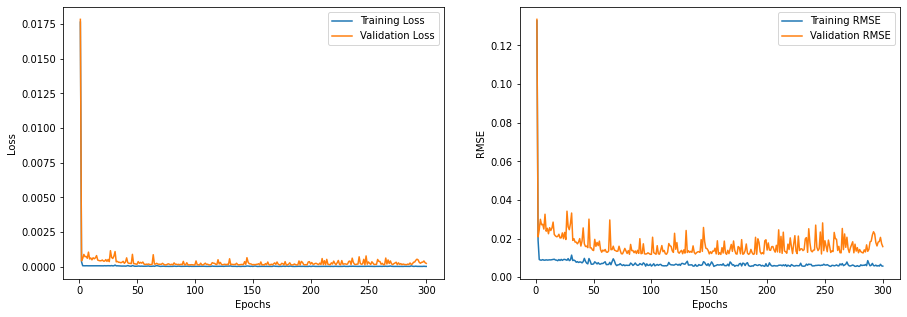

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 74.35 RMSE
Test Score: 221.23 RMSE
*************************
train MAPE :  0.0077716744799549405
test MAPE :  0.012768952508462635


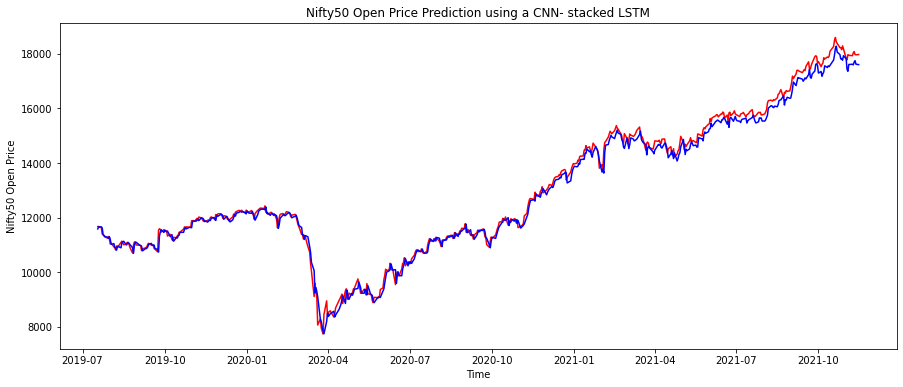

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_5.predict(X_train)
y_val_predict=cnn_lstm_5.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_ccl = scaler.inverse_transform(y_train)
y_val_ccl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_ccl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_ccl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))


print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_ccl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_ccl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using a CNN- stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


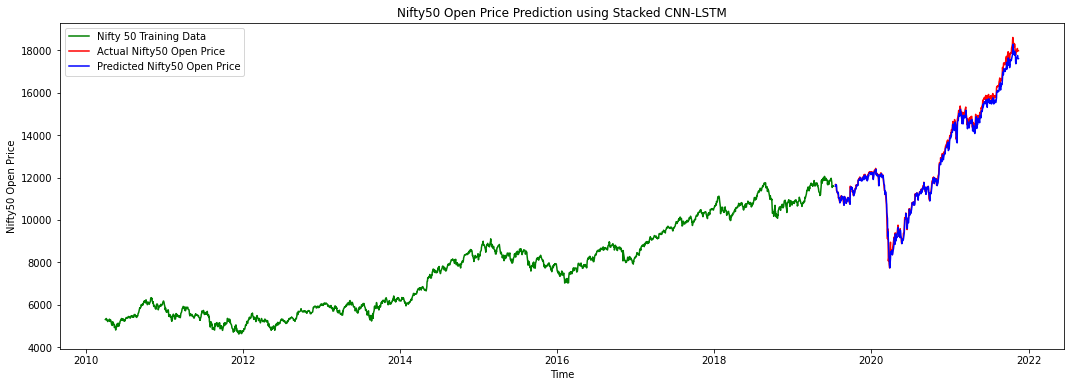

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_ccl)].index, y_train_ccl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()